In [4]:
%matplotlib notebook

import math
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D  
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from simulation_view import SimulationView

In [148]:
def get_simulation_view():
#     return SimulationView(np.array([random.random(), random.random()]) * 10000 + 5000, [0, 0])
    return SimulationView([5000, 10000], [0, 0])


class Environment(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, **kwargs):
        super(Environment, self).__init__()
        self.reward_range = (-math.inf, -math.inf)
        self.action_space = gym.spaces.Box(np.array([0]), np.array([1]), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=1e5, shape=(2,))
        self.simulation_view = get_simulation_view()
        self.simulation_step = 0
        self.plot_x = np.array([])
        self.plot_y = np.array([])
        self.draw_plot = kwargs.get('draw_plot')
        self.draw_plot_freq = kwargs.get('draw_plot_freq')

    def step(self, action): 
        self.last_action = action
        old_obs = list(self.simulation_view.simulation.entityCount)
        self.simulation_view.step([action[0] * 1e5, 0])
        print(old_obs, action[0])
        obs = np.array(self.simulation_view.simulation.entityCount)
        self.plot_x = np.append(self.plot_x, obs[0])
        self.plot_y = np.append(self.plot_y, obs[1])
        # reward = 1e5 - np.abs(self.simulation_view.simulation.entityCount[0] - self.simulation_view.simulation.entityCount[1])
        # reward = self.simulation_step
        # reward = 1
        reward = 100 / (100 + np.sum(np.abs(obs - old_obs)))
        # reward = 1 - min(abs(1 - np.average(np.array(obs) / np.array(old_obs))), 1)
        # reward = 2000 - np.sum(np.abs(obs - old_obs))
        # reward = 1 if action[0] > 0.4 and action[0] < 0.6 else 0
        # reward = -1 if np.any(np.array(self.simulation_view.simulation.entityCount) < 100) else 1
        # reward = 10000.0 - abs(5000 - obs[0]) - abs(5000 - obs[1])
        # reward = (30000.0 - obs[0] - obs[1]) / 30000.0
        done = bool(np.any(np.array(self.simulation_view.simulation.entityCount) < 1000)) \
               or bool(self.simulation_step > 100)
               # or bool(np.sum(np.abs(obs - old_obs)) > (1000 - self.simulation_step) * 2)
              
        self.simulation_step += 1

        return obs, reward, done, {}

    def reset(self):
        self.simulation_view = get_simulation_view()
        self.simulation_step = 0
        self.plot_x = np.array([])
        self.plot_y = np.array([])
        return np.array(self.simulation_view.simulation.entityCount)

    def render(self, mode='human', close=False):
        if self.simulation_step != 0 and self.simulation_step % self.draw_plot_freq == 0:
            self.draw_plot(self.plot_x, self.plot_y)
        
        
check_env(Environment())

[5000, 10000] 0.29732442
[4970, 9000] 0.86331177
[5209, 8095] 0.21712609
[5337, 7319] 0.9070246
[5821, 6636] 0.7906349
[6424, 6081] 0.09154016
[6405, 5646] 0.94275814
[7242, 5240] 0.7650282
[8204, 4951] 0.56448203
[9234, 4773] 0.8668132
[10537, 4700] 0.8970291


In [154]:
def get_empty_model():
    env = Environment()
    return PPO('MlpPolicy', env, clip_range=0.1, verbose=1, tensorboard_log="./logs/")


def learn_model(steps=100000, **kwargs):
    def draw_plot(x, y):
        ax.lines[0].set_xdata(x)
        ax.lines[0].set_ydata(y)
        fig.canvas.draw()

    eval_callback=None
    if kwargs.get('evaluate'):
        fig, ax = plt.subplots(1,1)
        ax.plot([0, 20000], [0, 20000])
        eval_callback = EvalCallback(Environment(draw_plot=draw_plot, draw_plot_freq=10), best_model_save_path='./logs/',
                                     log_path='./logs/', eval_freq=kwargs.get('eval_freq', 10000), render=True)
    
    model = get_empty_model()
    model.learn(total_timesteps=steps, callback=eval_callback)
    return model


def evaluate_model(model, **kwargs):
    def draw_plot(x, y):
        ax.lines[0].set_xdata(x)
        ax.lines[0].set_ydata(y)
        fig.canvas.draw()
    fig, ax = plt.subplots(1,1)
    ax.plot([0, 20000], [0, 20000])
    
    env = Environment(draw_plot=draw_plot, draw_plot_freq=kwargs.get('draw_plot_freq', 10))
    evaluate_policy(model, env, render=True)
    

def draw_model_surface(model):
    def fun(x, y):
        return list(map(lambda x: model.predict([x[0], x[1]], deterministic=True)[0][0], zip(x, y)))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(5000, 10000, 100)
    X, Y = np.meshgrid(x, y)
    zs = np.array(fun(np.ravel(X), np.ravel(Y)))
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z)
    plt.show()

In [146]:
model = learn_model(10000, evaluate=True, eval_freq=1000)

<IPython.core.display.Javascript object>

Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/PPO_23
[10000, 5000] 0.0
[8100, 5000] 0.3486731
[8927, 4810] 0.0
[7261, 4707] 1.0
[8373, 4449] 0.37068373
[9354, 4304] 0.5044811
[10579, 4248] 0.0
[8712, 4297] 0.0
[7167, 4186] 1.0
[8361, 3949] 0.8814942
[9744, 3820] 0.0
[8100, 3800] 1.0
[9505, 3656] 0.0
[7929, 3620] 0.0
[6619, 3470] 0.16906095
[7314, 3235] 1.0
[8707, 3061] 0.0
[7357, 2982] 0.0
[6226, 2824] 0.0
[5287, 2611] 0.0
[4510, 2365] 0.10330772
[5063, 2105] 0.85168856
[6196, 1897] 0.52612644
[7498, 1753] 1.0
[9204, 1665] 0.0
[8008, 1638] 0.0
[6971, 1573] 0.0
[6077, 1478] 0.0
[5308, 1362] 0.6216029
[6550, 1234] 0.6056207
[8055, 1149] 1.0
[9996, 1104] 0.6185255
[12164, 1104] 0.0
[10706, 1152] 0.18063909
[12040, 1168] 0.26131997
[13803, 1216] 0.0
[12121, 1308] 0.0
[10624, 1363] 0.0
[9301, 1380] 0.014937121
[8640, 1361] 0.0
[7564, 1324] 1.0
[9366, 1259] 0.0
[8217, 1243] 0.0
[7211, 1199] 0.28601775
[8583, 1132] 0.9646091
[10631, 1100] 0.28638273
[12390, 1114] 0.48

[12539, 6271] 0.0
[9870, 6589] 1.0
[10832, 6572] 0.0
[8467, 6681] 0.35495818
[8971, 6476] 0.0
[7028, 6343] 0.01780738
[6019, 5966] 0.0
[4771, 5491] 0.0
[3822, 4917] 0.0
[3102, 4309] 0.0
[2551, 3715] 0.0
[2125, 3162] 0.34470326
[2542, 2664] 0.0
[2166, 2267] 0.0
[1861, 1912] 0.0
[1611, 1601] 0.0
[1403, 1332] 0.0
[1229, 1103] 1.0
[10000, 5000] 0.0
[8100, 5000] 0.44456893
[9028, 4810] 0.62268215
[10194, 4716] 1.0
[11661, 4734] 0.0
[9501, 4891] 0.0
[7714, 4842] 0.0
[6270, 4621] 0.24614124
[6936, 4276] 0.0
[5709, 4014] 0.7117765
[6670, 3670] 0.0
[5562, 3426] 0.05109203
[5655, 3122] 0.38745645
[6622, 2851] 0.0
[5620, 2658] 0.0
[4789, 2425] 0.0
[4101, 2172] 0.0
[3531, 1916] 1.0
[4368, 1668] 0.0
[3800, 1480] 1.0
[4740, 1296] 0.0
[4155, 1160] 0.0
[3653, 1024] 0.0
[10000, 5000] 0.0
[8100, 5000] 0.4995371
[9070, 4810] 0.07833283
[8897, 4721] 0.15223463
[9285, 4617] 0.0
[7585, 4551] 0.0
[6205, 4331] 0.7877781
[7202, 4002] 0.0
[5963, 3778] 1.0
[7042, 3473] 0.0
[5898, 3268] 0.50032544
[6934, 3000] 0.

KeyboardInterrupt: 

In [136]:
model = PPO.load("logs/best_model.zip")

<IPython.core.display.Javascript object>


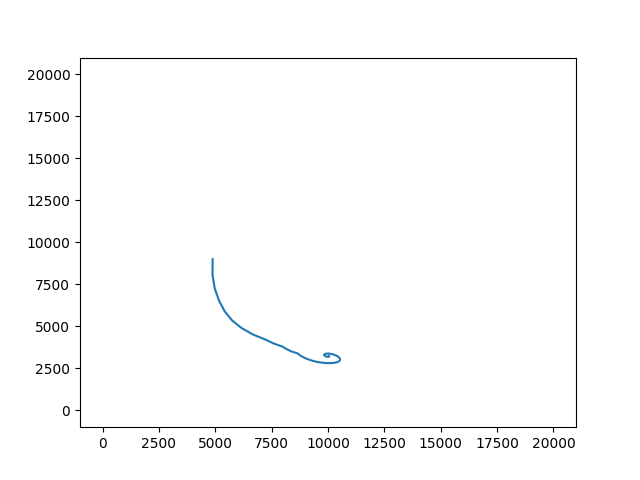

[5000, 10000] 0.20264795
[4883, 9000] 0.18836862
[4876, 8079] 0.18836862
[4978, 7251] 0.18309367
[5169, 6523] 0.16788557
[5420, 5893] 0.16691962
[5747, 5353] 0.1784096
[6171, 4898] 0.17727643
[6661, 4523] 0.17727643
[7214, 4221] 0.1183851
[7586, 3986] 0.11838507
[7985, 3794] 0.08644322
[8176, 3641] 0.08644322
[8381, 3508] 0.09255958
[8650, 3394] 0.07334095
[8736, 3302] 0.07334095
[8833, 3219] 0.07334095
[8938, 3144] 0.07334095
[9048, 3077] 0.07334095
[9163, 3018] 0.07334095
[9280, 2967] 0.07334095
[9398, 2924] 0.07334095
[9515, 2889] 0.07334095
[9630, 2861] 0.07334095
[9741, 2840] 0.07334095
[9847, 2825] 0.07334095
[9948, 2816] 0.07334095
[10043, 2813] 0.07334095
[10130, 2815] 0.07334095
[10210, 2822] 0.07334095
[10281, 2834] 0.07334095
[10344, 2850] 0.07334095
[10398, 2870] 0.07334095
[10443, 2893] 0.07334095
[10479, 2919] 0.07334095
[10506, 2947] 0.07334095
[10524, 2977] 0.07334095
[10534, 3008] 0.07334095
[10536, 3040] 0.07334095
[10530, 3073] 0.07334095
[10517, 3106] 0.07334095
[10

[10517, 3106] 0.07334095
[10498, 3138] 0.07334095
[10474, 3169] 0.07334095
[10445, 3199] 0.07334095
[10412, 3227] 0.07334095
[10376, 3254] 0.07334095
[10338, 3278] 0.07334095
[10298, 3300] 0.07334095
[10257, 3320] 0.07334095
[10215, 3337] 0.07334095
[10174, 3351] 0.07334095
[10133, 3363] 0.07334095
[10094, 3372] 0.07334095
[10056, 3378] 0.07334095
[10021, 3382] 0.07334095
[9988, 3383] 0.07334095
[9958, 3382] 0.07334095
[9931, 3379] 0.07334095
[9907, 3374] 0.07334095
[9887, 3368] 0.07334095
[9870, 3360] 0.07334095
[9856, 3351] 0.07334095
[9845, 3341] 0.07334095
[9837, 3331] 0.07334095
[9832, 3320] 0.07334095
[9830, 3309] 0.07334095
[9830, 3298] 0.07334095
[9833, 3287] 0.07334095
[9838, 3276] 0.07334095
[9845, 3265] 0.07334095
[9853, 3255] 0.07334095
[9863, 3245] 0.07334095
[9874, 3236] 0.07334095
[9886, 3228] 0.07334095
[9898, 3221] 0.07334095
[9911, 3214] 0.07334095
[9924, 3208] 0.07334095
[9937, 3203] 0.07334095
[9950, 3199] 0.07334095
[9963, 3196] 0.07334095
[9975, 3194] 0.07334095
[

[10052, 3208] 0.07334095
[10054, 3211] 0.07334095
[10055, 3214] 0.07334095
[10055, 3218] 0.07334095
[10054, 3222] 0.07334095
[10052, 3225] 0.07334095
[10050, 3228] 0.07334095
[10048, 3231] 0.07334095
[10045, 3234] 0.07334095
[10042, 3237] 0.07334095
[10038, 3240] 0.07334095
[5000, 10000] 0.20264795
[4883, 9000] 0.18836862
[4876, 8079] 0.18836862
[4978, 7251] 0.18309367
[5169, 6523] 0.16788557
[5420, 5893] 0.16691962
[5747, 5353] 0.1784096
[6171, 4898] 0.17727643
[6661, 4523] 0.17727643
[7214, 4221] 0.1183851
[7586, 3986] 0.11838507
[7985, 3794] 0.08644322
[8176, 3641] 0.08644322
[8381, 3508] 0.09255958
[8650, 3394] 0.07334095
[8736, 3302] 0.07334095
[8833, 3219] 0.07334095
[8938, 3144] 0.07334095
[9048, 3077] 0.07334095
[9163, 3018] 0.07334095
[9280, 2967] 0.07334095
[9398, 2924] 0.07334095
[9515, 2889] 0.07334095
[9630, 2861] 0.07334095
[9741, 2840] 0.07334095
[9847, 2825] 0.07334095
[9948, 2816] 0.07334095
[10043, 2813] 0.07334095
[10130, 2815] 0.07334095
[10210, 2822] 0.07334095
[10

In [152]:
evaluate_model(model)

<IPython.core.display.Javascript object>


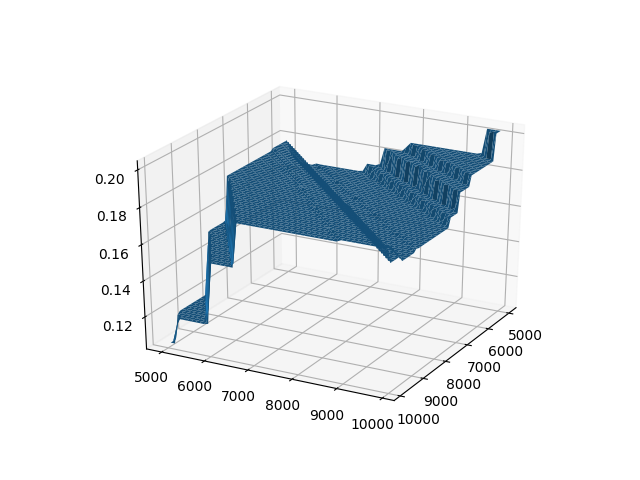

In [155]:
draw_model_surface(model)